In [72]:
import numpy as np
import sklearn 
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from latexify import *
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [2]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        logits = self.linear(x)
        return logits

In [3]:
from sklearn.datasets import make_moons

In [4]:
X, y = make_moons(n_samples=100, noise=0.1)

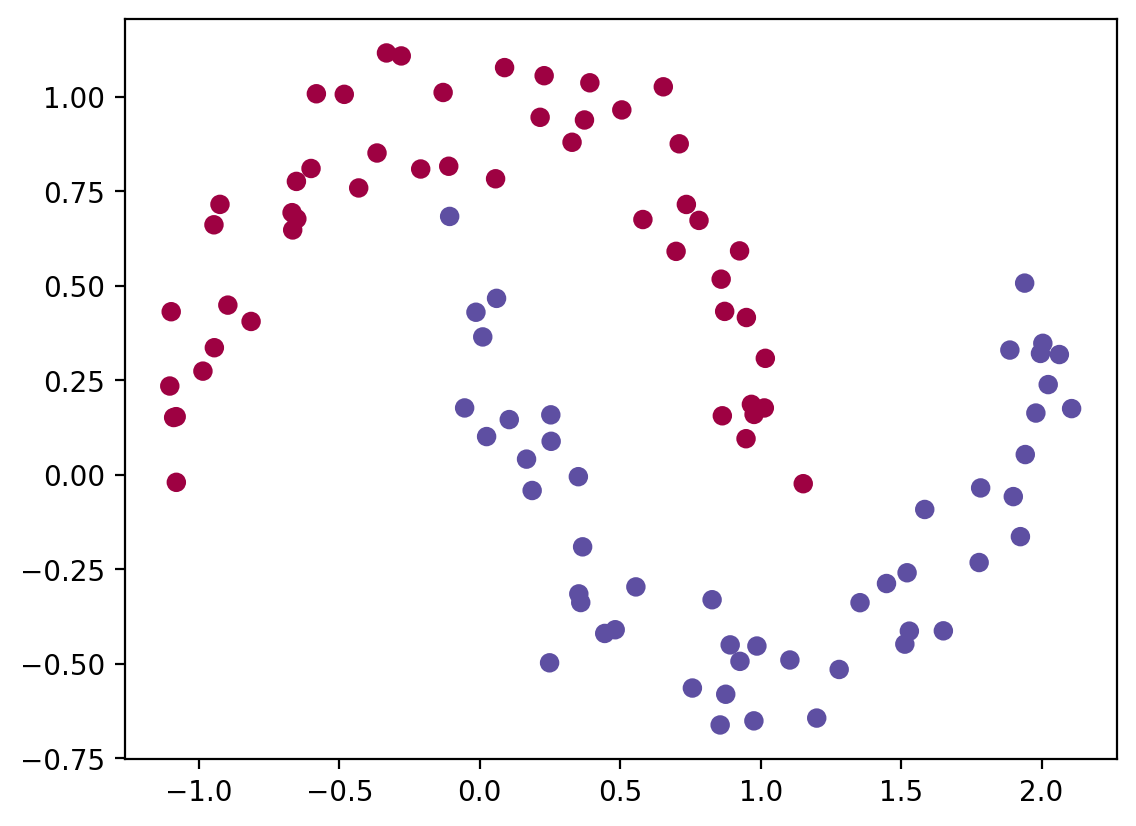

In [25]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

In [29]:
log_reg = LogisticRegression(2)

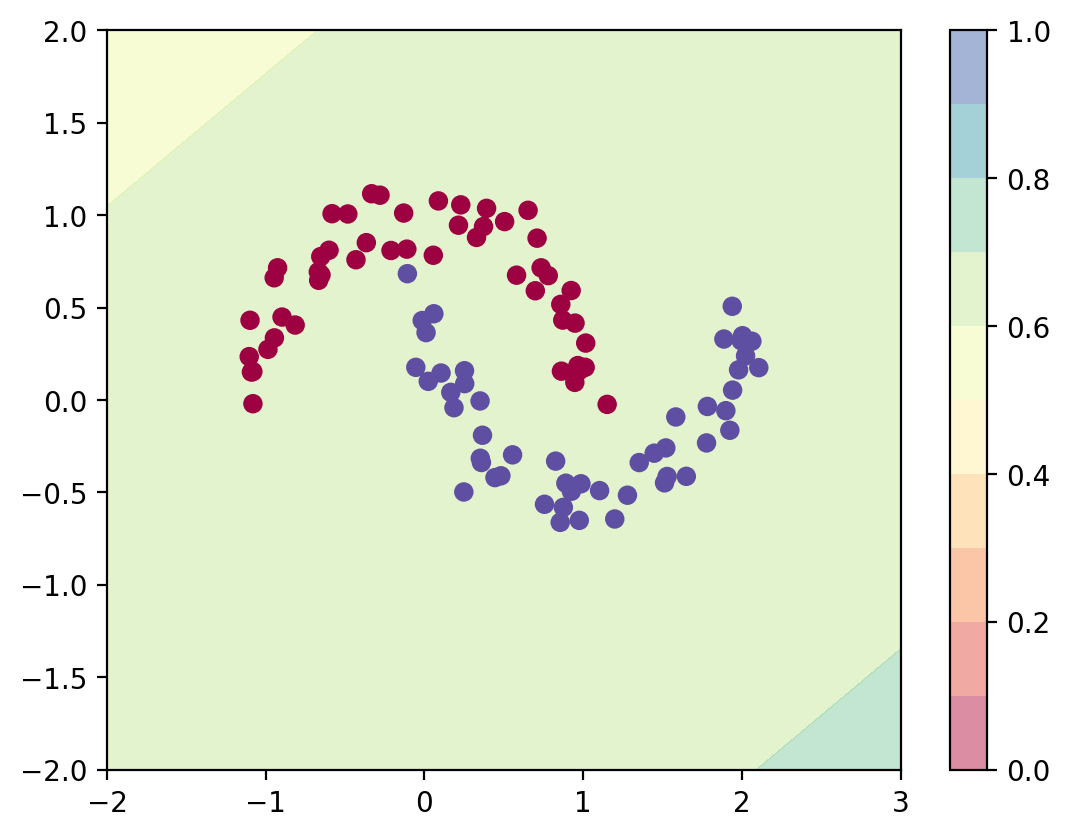

In [30]:
# Predict with the model

def predict_plot_grid(model):
    XX, YY = torch.meshgrid(torch.linspace(-2, 3, 100), torch.linspace(-2, 2, 100))
    X_grid = torch.cat([XX.unsqueeze(-1), YY.unsqueeze(-1)], dim=-1)
    logits = model(X_grid)
    probs = torch.sigmoid(logits).reshape(100, 100)
    plt.contourf(XX, YY, probs.detach().numpy(), levels=[0.0, 0.1, 0.2,0.3, 0.4,0.5, 0.6,0.7, 0.8,0.9, 1.0], 
                 cmap=plt.cm.Spectral, alpha=0.5)
    plt.colorbar()
    
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    
predict_plot_grid(log_reg)
    
    

In [31]:


opt = torch.optim.Adam(log_reg.parameters(), lr=0.01)

converged = False
prev_loss = 1e8 
i = 0
while not converged:
    opt.zero_grad()
    logits = log_reg(torch.tensor(X, dtype=torch.float32))
    loss = nn.BCEWithLogitsLoss()(logits, torch.tensor(y, dtype=torch.float32).view(-1, 1))
    loss.backward()
    opt.step()
    if i%10==0:
        print(i, loss.item())
    if np.abs(prev_loss - loss.item()) < 1e-5:
        converged = True
    prev_loss = loss.item() 
    i = i + 1


0 0.7104504108428955
10 0.6601136922836304
20 0.6153445243835449
30 0.576545000076294
40 0.5435934662818909
50 0.5159685015678406
60 0.4929444193840027
70 0.47375598549842834
80 0.45769837498664856
90 0.4441695511341095
100 0.4326764643192291
110 0.4228237569332123
120 0.41429755091667175
130 0.4068489968776703
140 0.40028053522109985
150 0.3944348096847534
160 0.389186292886734
170 0.38443419337272644
180 0.38009756803512573
190 0.3761110305786133
200 0.3724215626716614
210 0.36898621916770935
220 0.3657699525356293
230 0.36274418234825134
240 0.359885573387146
250 0.35717469453811646
260 0.3545958995819092
270 0.35213592648506165
280 0.3497839868068695
290 0.34753093123435974
300 0.3453693091869354
310 0.34329262375831604
320 0.34129542112350464
330 0.3393731713294983
340 0.3375217318534851
350 0.3357376456260681
360 0.33401787281036377
370 0.33235955238342285
380 0.33076024055480957
390 0.3292176127433777
400 0.32772961258888245
410 0.3262942135334015
420 0.3249095678329468
430 0.32

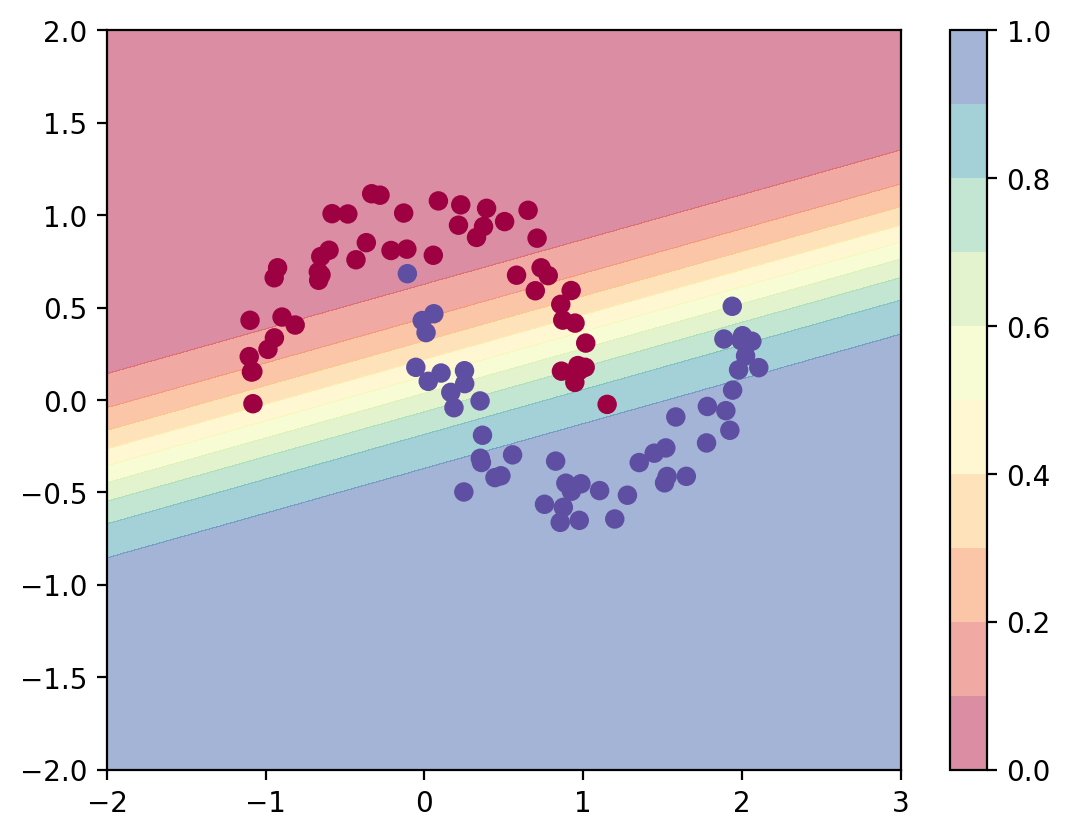

In [32]:
predict_plot_grid(log_reg)

In [33]:
# Iris dataset
from sklearn.datasets import load_iris
iris = load_iris()

In [36]:
X = iris.data
y = iris.target

Text(0, 0.5, 'Sepal width')

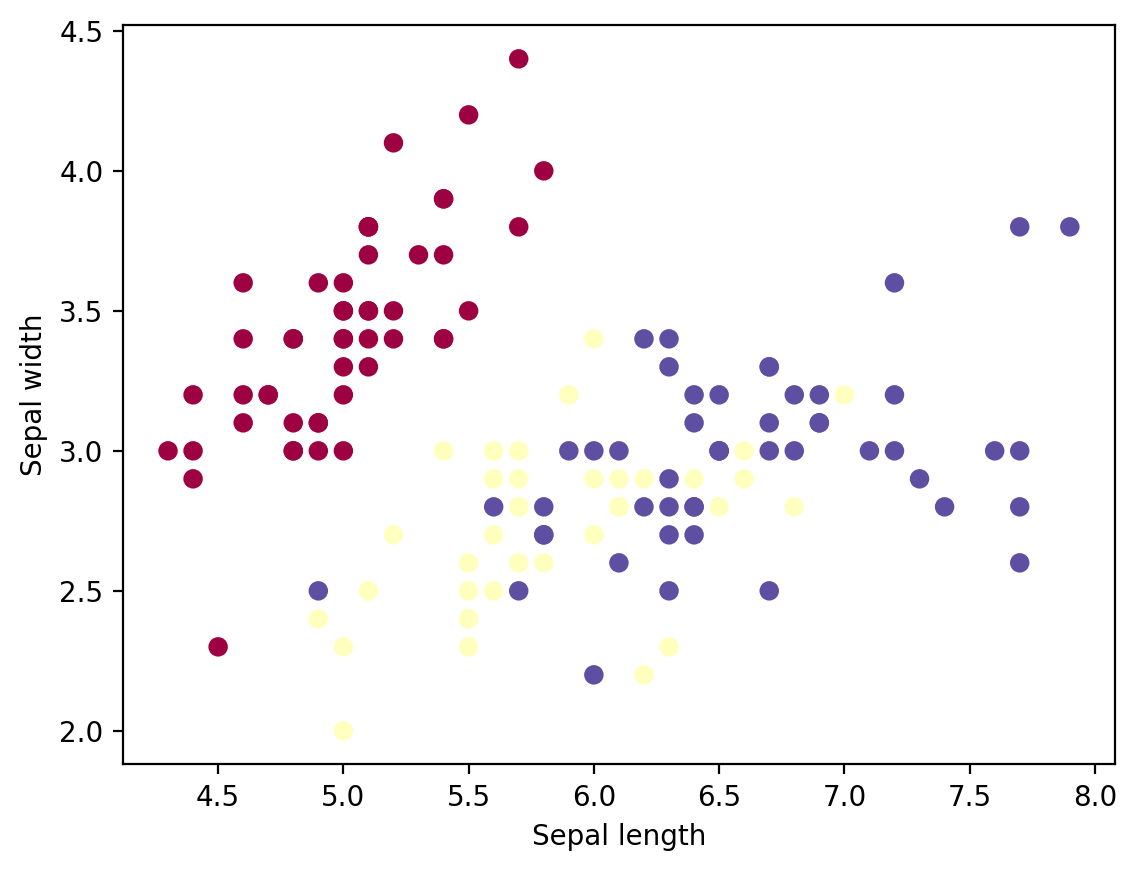

In [39]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

In [55]:
class ThreeClassLogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(ThreeClassLogisticRegression, self).__init__()
        self.linear1 = nn.Linear(input_dim, 1)
        self.linear2 = nn.Linear(input_dim, 1)
        self.linear3 = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        logits1 = self.linear1(x)
        logits2 = self.linear2(x)
        logits3 = self.linear3(x)
        return torch.cat([logits1, logits2, logits3], dim=-1)
    

class MultiClassLogisticRegression(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MultiClassLogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, num_classes)
    
    def forward(self, x):
        logits = self.linear(x)
        return logits

In [52]:
mlr = ThreeClassLogisticRegression(2)

In [89]:
X_tensor = torch.tensor(X, dtype=torch.float32)[:,:2]
y_tensor = torch.tensor(y, dtype=torch.long)

In [90]:
mlr(X_tensor).shape

torch.Size([150, 3])

In [91]:
mlr_efficient = MultiClassLogisticRegression(2, 3)
mlr_efficient(X_tensor).shape

torch.Size([150, 3])

In [92]:
mlr_efficient(X_tensor[:5])

tensor([[ 1.6853,  5.9457, -0.9022],
        [ 1.8023,  5.4911, -0.9884],
        [ 1.6162,  5.4920, -0.8269],
        [ 1.6097,  5.3623, -0.8170],
        [ 1.5923,  5.9462, -0.8215]], grad_fn=<AddmmBackward0>)

In [93]:

nn.Softmax(dim=-1)(mlr_efficient(X_tensor[:5])).sum(dim=-1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<SumBackward1>)

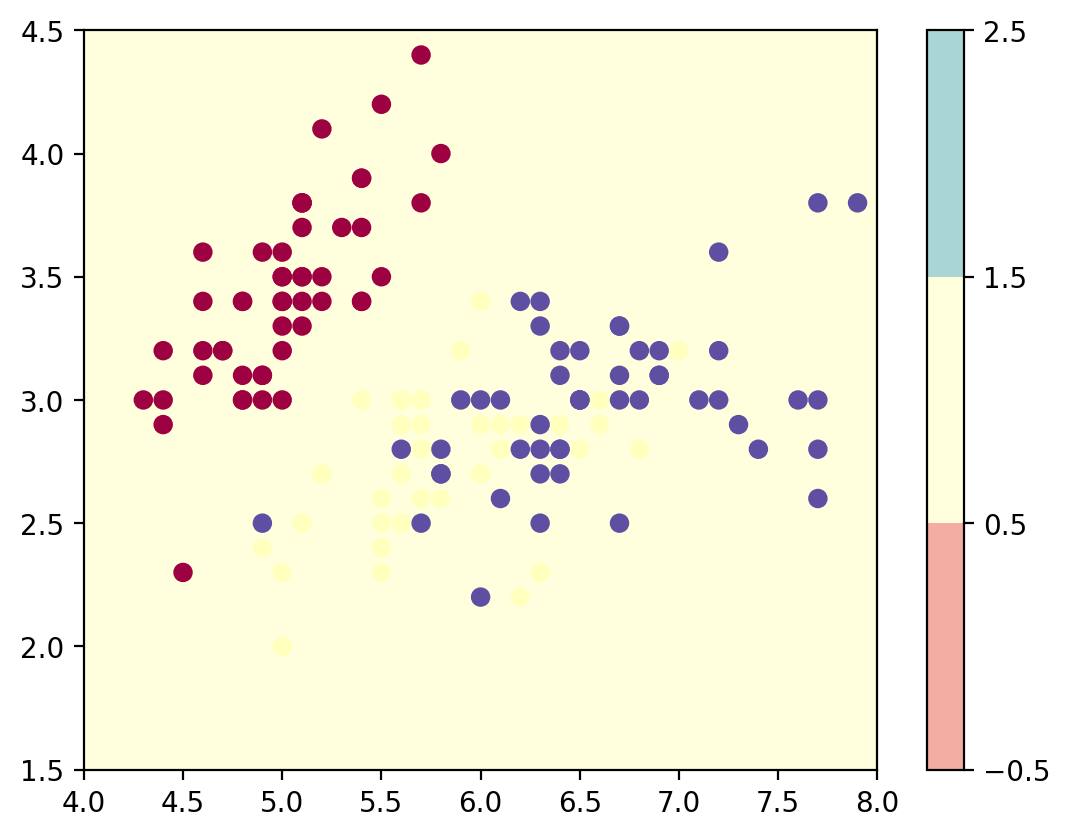

In [95]:
def plot_most_probable_class(model):
    XX, YY = torch.meshgrid(torch.linspace(4, 8, 100), torch.linspace(1.5, 4.5, 100))
    X_grid = torch.cat([XX.unsqueeze(-1), YY.unsqueeze(-1)], dim=-1)
    logits = model(X_grid)
    predicted_class = torch.argmax(logits, dim=-1)
    plt.contourf(XX, YY, predicted_class.reshape(100, 100).detach().numpy(), levels=[-0.5, 0.5, 1.5, 2.5], 
                 cmap=plt.cm.Spectral, alpha=0.5)
    plt.colorbar()

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    
plot_most_probable_class(mlr_efficient)

In [96]:
logits = mlr_efficient(X_tensor)
nn.Softmax(dim=-1)(logits[:5])

tensor([[0.0139, 0.9850, 0.0010],
        [0.0244, 0.9742, 0.0015],
        [0.0203, 0.9780, 0.0018],
        [0.0229, 0.9751, 0.0020],
        [0.0127, 0.9862, 0.0011]], grad_fn=<SoftmaxBackward0>)

In [97]:
opt = torch.optim.Adam(mlr_efficient.parameters(), lr=0.01)

converged = False
prev_loss = 1e8

i = 0
while not converged:
    opt.zero_grad()
    logits = mlr_efficient(X_tensor)
    loss = F.cross_entropy(logits, y_tensor)
    loss.backward()
    opt.step()
    if i%10==0:
        print(i, loss.item())
    if np.abs(prev_loss - loss.item()) < 1e-5:
        converged = True
    prev_loss = loss.item() 
    i = i + 1

0 4.188741683959961
10 2.9877233505249023
20 2.2360727787017822
30 1.7865716218948364
40 1.429468035697937
50 1.3531132936477661
60 1.3468083143234253
70 1.3115711212158203
80 1.289126992225647
90 1.267372488975525
100 1.2450817823410034
110 1.222923755645752
120 1.2007617950439453
130 1.178642988204956
140 1.1566882133483887
150 1.1349910497665405
160 1.1136341094970703
170 1.0926913022994995
180 1.0722216367721558
190 1.0522767305374146
200 1.0328959226608276


210 1.014109492301941
220 0.9959387183189392
230 0.9783971309661865
240 0.9614909887313843
250 0.9452206492424011
260 0.9295811057090759
270 0.9145632982254028
280 0.9001539945602417
290 0.8863378167152405
300 0.8730966448783875
310 0.860410749912262
320 0.8482595086097717
330 0.8366215229034424
340 0.8254750370979309
350 0.8147982358932495
360 0.8045694828033447
370 0.7947672605514526
380 0.7853711247444153
390 0.7763609290122986
400 0.767717182636261
410 0.7594213485717773
420 0.7514556646347046
430 0.743803083896637
440 0.7364473938941956
450 0.7293732166290283
460 0.7225661873817444
470 0.7160122990608215
480 0.7096987366676331
490 0.7036131024360657
500 0.6977436542510986
510 0.6920798420906067
520 0.686610758304596
530 0.681327223777771
540 0.6762197017669678
550 0.6712797284126282
560 0.6664990186691284
570 0.661870002746582
580 0.657385528087616
590 0.6530384421348572
600 0.6488226652145386
610 0.644731879234314
620 0.640760600566864
630 0.6369032263755798
640 0.633154809474945

In [98]:
mlr_efficient(X_tensor[:5])

tensor([[ 6.2944,  1.0090, -0.5611],
        [ 4.0149,  1.8758, -0.2229],
        [ 6.2074,  1.2734, -1.0656],
        [ 6.0260,  1.3920, -1.1495],
        [ 7.3907,  0.7078, -0.9824]], grad_fn=<AddmmBackward0>)

In [99]:
pred = F.softmax(mlr_efficient(X_tensor), dim=-1).detach().numpy()

In [100]:
import pandas as pd

In [101]:
df = pd.DataFrame(pred, columns=iris.target_names)
df["GT"] = iris.target
df

,setosa,versicolor,virginica,GT
0,0.993919,0.005034,0.001047,0
1,0.883233,0.104013,0.012753,0
2,0.992170,0.007141,0.000689,0
3,0.989627,0.009616,0.000757,0
4,0.998519,0.001250,0.000231,0
...,...,...,...,...
145,0.000135,0.308793,0.691072,2
146,0.000029,0.511445,0.488526,2
147,0.000498,0.381384,0.618117,2
148,0.084919,0.420189,0.494892,2


In [102]:
# Find prediction
y_pred = pred.argmax(axis=-1)

df["Predicted Class"] = y_pred


In [103]:
df

,setosa,versicolor,virginica,GT,Predicted Class
0,0.993919,0.005034,0.001047,0,0
1,0.883233,0.104013,0.012753,0,0
2,0.992170,0.007141,0.000689,0,0
3,0.989627,0.009616,0.000757,0,0
4,0.998519,0.001250,0.000231,0,0
...,...,...,...,...,...
145,0.000135,0.308793,0.691072,2,2
146,0.000029,0.511445,0.488526,2,1
147,0.000498,0.381384,0.618117,2,2
148,0.084919,0.420189,0.494892,2,2


In [104]:
# Accuracy
(y_pred == iris.target).mean()

0.8266666666666667

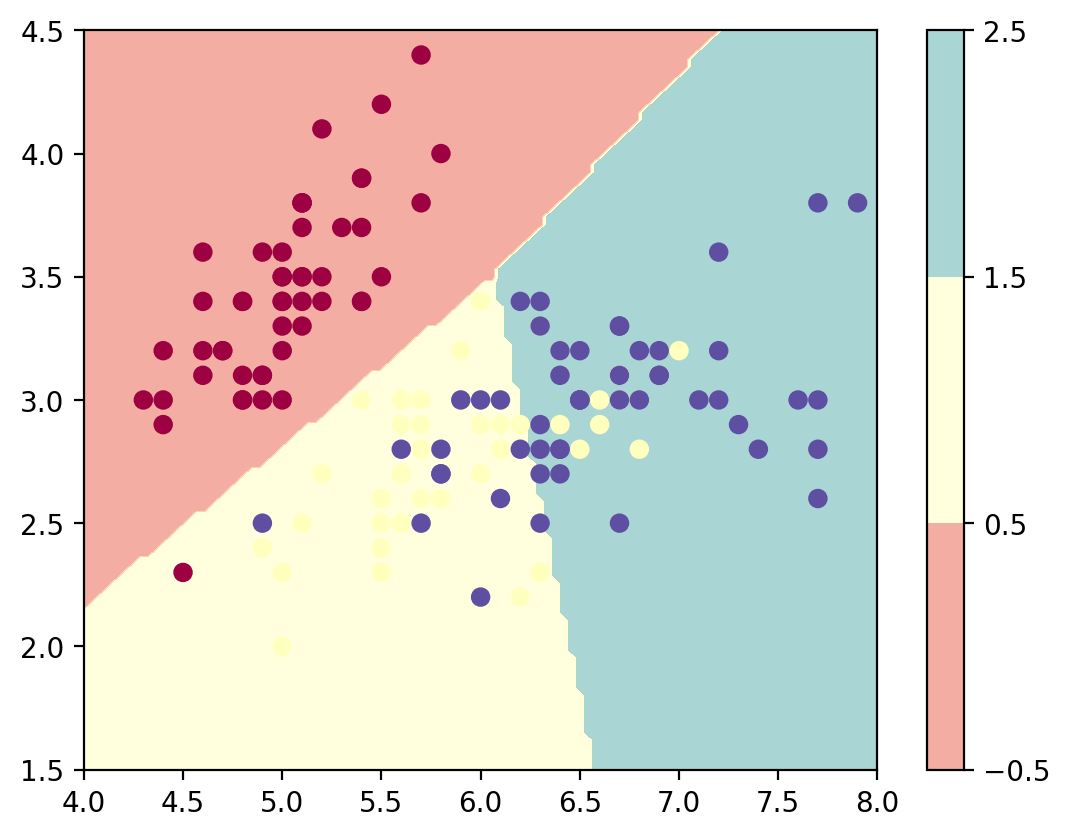

In [105]:
plot_most_probable_class(mlr_efficient)

In [86]:
# Add more features like x^2, xy, y^2

X = iris.data
y = iris.target

X = np.concatenate([X, X**2, X[:, [0]]*X[:, [1]], X[:, [1]]**2], axis=-1)

X_tensor = torch.tensor(X, dtype=torch.float32)

mlr_efficient = MultiClassLogisticRegression(10, 3)


opt = torch.optim.Adam(mlr_efficient.parameters(), lr=0.01)

converged = False

prev_loss = 1e8

i = 0
while not converged:
    opt.zero_grad()
    logits = mlr_efficient(X_tensor)
    loss = F.cross_entropy(logits, y_tensor)
    loss.backward()
    opt.step()
    if i%10==0:
        print(i, loss.item())
    if np.abs(prev_loss - loss.item()) < 1e-5:
        converged = True
    prev_loss = loss.item() 
    i = i + 1
    


0 4.386221408843994
10 1.3555710315704346
20 0.539000928401947
30 0.391224205493927
40 0.3121725618839264
50 0.27308228611946106
60 0.24870391190052032
70 0.22769100964069366
80 0.21121273934841156
90 0.19696174561977386
100 0.18461136519908905
110 0.17376990616321564
120 0.1641765683889389
130 0.15566210448741913
140 0.14806975424289703
150 0.1412755846977234
160 0.13517214357852936
170 0.12966902554035187
180 0.12468919157981873
190 0.1201673224568367
200 0.11604750156402588
210 0.11228205263614655
220 0.10883000493049622
230 0.10565614700317383
240 0.102729931473732
250 0.1000249832868576
260 0.09751836955547333
270 0.0951899066567421
280 0.09302214533090591
290 0.09099956601858139
300 0.0891086608171463
310 0.08733730763196945
320 0.08567488193511963
330 0.08411194384098053
340 0.08263996243476868
350 0.08125142008066177
360 0.0799395963549614
370 0.07869838923215866
380 0.07752230763435364
390 0.07640647143125534
400 0.07534641772508621
410 0.07433813065290451
420 0.07337787747383

In [87]:
# Accuracy
pred = F.softmax(mlr_efficient(X_tensor), dim=-1).detach().numpy()
y_pred = pred.argmax(axis=-1)
(y_pred == iris.target).mean()

0.9866666666666667